In [91]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [92]:
def read_h5_file(output_file):
    simulation_data = {}
    with h5py.File(output_file, 'r') as f:
        # Read global attributes safely
        attributes = {
            "total_chicken_population": f.attrs.get("total_chicken_population", None),
            "duck_symptomatic_probability": f.attrs.get("duck_symptomatic_probability", None),
            "rescale_factor": f.attrs.get("rescale_factor", None)
        }

        # Iterate over simulation groups
        for sim_name in f:
            sim_group = f[sim_name]
            
            if "time" in sim_group and "state" in sim_group:
                t = sim_group["time"][:]
                y = sim_group["state"][:]
                simulation_data[sim_name] = {"time": t, "state": y}
            else:
                print(f"Warning: Missing 'time' or 'state' in {sim_name}")

    return simulation_data, attributes

In [93]:
def if_outbreak(t, y, outbreak_threshold=5):
    """Determine if an outbreak occurs based on the final time step."""
    return np.sum(y[-1, :, :, 5:]) >= outbreak_threshold

In [94]:
def passive_surveillance(t, y, alert_threshold=2):
    """Find the first time passive surveillance detects an outbreak."""
    threshold_reached = np.where(np.sum(y[:, :, :, 6], axis=(1, 2)) >= alert_threshold)[0]

    if len(threshold_reached) > 0:
        return t[threshold_reached[0]], np.trapz(np.sum(y[:threshold_reached[0]+1, :, :, 3:5], axis=(1, 2, 3)), t[:threshold_reached[0]+1])
    else:
        return np.nan, np.nan


In [95]:
def create_df(simulation_data):
    """Create a DataFrame summarizing outbreak and detection times and store associated states."""
    results = []

    for sim_name, data in simulation_data.items():
        outbreak = if_outbreak(data["time"], data["state"])
        
        pas_2, y2 = passive_surveillance(data["time"], data["state"], alert_threshold=2)
        pas_4, y4 = passive_surveillance(data["time"], data["state"], alert_threshold=4)
        pas_6, y6 = passive_surveillance(data["time"], data["state"], alert_threshold=6)
        
        final_deaths = np.sum(data["state"][-1, :, :, 6:])
        final_removed = np.sum(data["state"][-1, :, :, 5:])

        results.append([sim_name, outbreak, pas_2, y2, pas_4, y4, pas_6, y6, final_deaths, final_removed])

    # Create DataFrame
    df = pd.DataFrame(results, columns=[
        "simulation", "outbreak", 
        "passive_surveillance_threshold_2", "y2_state", 
        "passive_surveillance_threshold_4", "y4_state", 
        "passive_surveillance_threshold_6", "y6_state",
        "final_deaths", "final_removed"
    ])

    # Convert detection time columns to numeric
    for col in ["passive_surveillance_threshold_2", "passive_surveillance_threshold_4", "passive_surveillance_threshold_6"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")  # Ensures NaNs are properly handled

    return df

In [96]:
# List of files corresponding to different chicken populations
chicken_levels = [0, 10, 20, 30, 40]
symprob = 0.2
rescale = 3.0
file_template = "Time_Series/chicken_{}_symprob_{}_rescale_{}.h5"

def process_files(chicken_levels):
    all_results = []

    for chicken in chicken_levels:
        output_file = file_template.format(chicken, symprob, rescale)
        simulation_data, attributes = read_h5_file(output_file)  # Read H5 file

        df = create_df(simulation_data)  # Create DataFrame
        df["chicken_population"] = chicken  # Add chicken level info

        all_results.append(df)  # Append to results list

    # Combine all into a single DataFrame
    combined_df = pd.concat(all_results, ignore_index=True)
    return combined_df

# Run the function
df_all = process_files(chicken_levels)


In [97]:

df_all.head(20)

,simulation,outbreak,passive_surveillance_threshold_2,y2_state,passive_surveillance_threshold_4,y4_state,passive_surveillance_threshold_6,y6_state,final_deaths,final_removed,chicken_population
0,simulation_1,True,5.365526,112.884813,15.557574,366.608968,NaN,NaN,4.0,40.0,0
1,simulation_10,True,3.815058,37.541133,6.094434,109.210566,NaN,NaN,5.0,40.0,0
2,simulation_100,True,2.023871,14.745381,8.661771,185.837377,11.217878,227.810613,7.0,40.0,0
3,simulation_1000,True,3.717079,42.033311,NaN,NaN,NaN,NaN,3.0,40.0,0
4,simulation_1001,False,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0
5,simulation_1002,True,4.027660,43.747033,7.182505,126.969830,9.739691,180.415241,9.0,40.0,0
6,simulation_1003,False,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0
7,simulation_1004,True,8.459746,119.354470,13.821660,241.719491,NaN,NaN,4.0,40.0,0
8,simulation_1005,True,2.401495,17.228537,3.022897,32.289530,4.819797,85.939890,8.0,40.0,0
9,simulation_1006,True,3.913993,41.692441,6.608340,127.930858,NaN,NaN,5.0,40.0,0


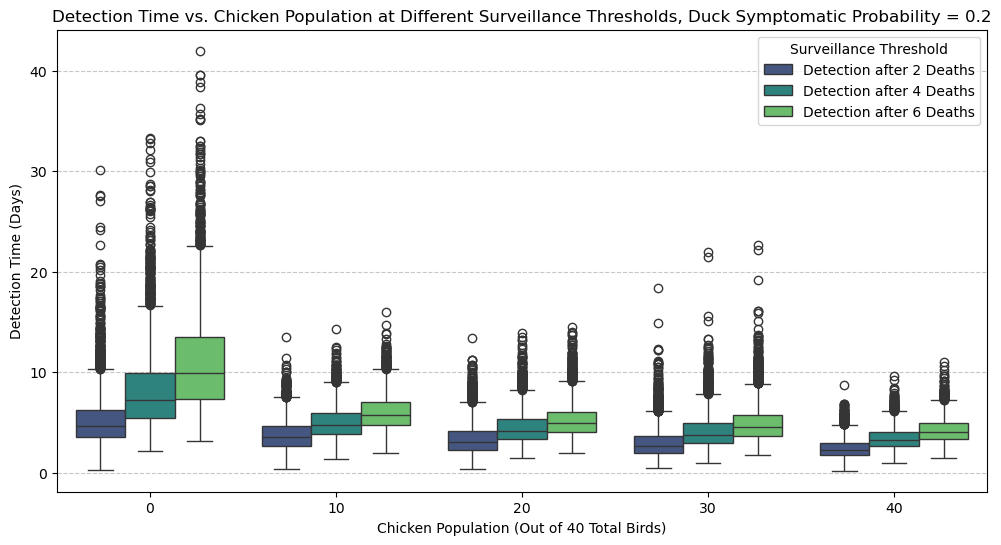

In [98]:
# Reshape the dataframe to long format for multiple thresholds
df_melted = df_all.melt(
    id_vars=["chicken_population"], 
    value_vars=["passive_surveillance_threshold_2", "passive_surveillance_threshold_4", "passive_surveillance_threshold_6"],
    var_name="Surveillance Threshold",
    value_name="Detection Time"
)

# Drop NaN values for visualization
df_melted = df_melted.dropna(subset=["Detection Time"])

# Map threshold names to more readable labels
threshold_labels = {
    "passive_surveillance_threshold_2": "Detection after 2 Deaths",
    "passive_surveillance_threshold_4": "Detection after 4 Deaths",
    "passive_surveillance_threshold_6": "Detection after 6 Deaths"
}
df_melted["Surveillance Threshold"] = df_melted["Surveillance Threshold"].map(threshold_labels)

# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="chicken_population", 
    y="Detection Time", 
    hue="Surveillance Threshold",
    data=df_melted, 
    palette="viridis"
)

# Labels and title
plt.xlabel("Chicken Population (Out of 40 Total Birds)")
plt.ylabel("Detection Time (Days)")
plt.title(f"Detection Time vs. Chicken Population at Different Surveillance Thresholds, Duck Symptomatic Probability = {symprob}")
plt.legend(title="Surveillance Threshold")
plt.grid(axis="y", linestyle="--", alpha=0.7)
#plt.ylim(0, 20)  # Limit y-axis for better visualization

plt.show()



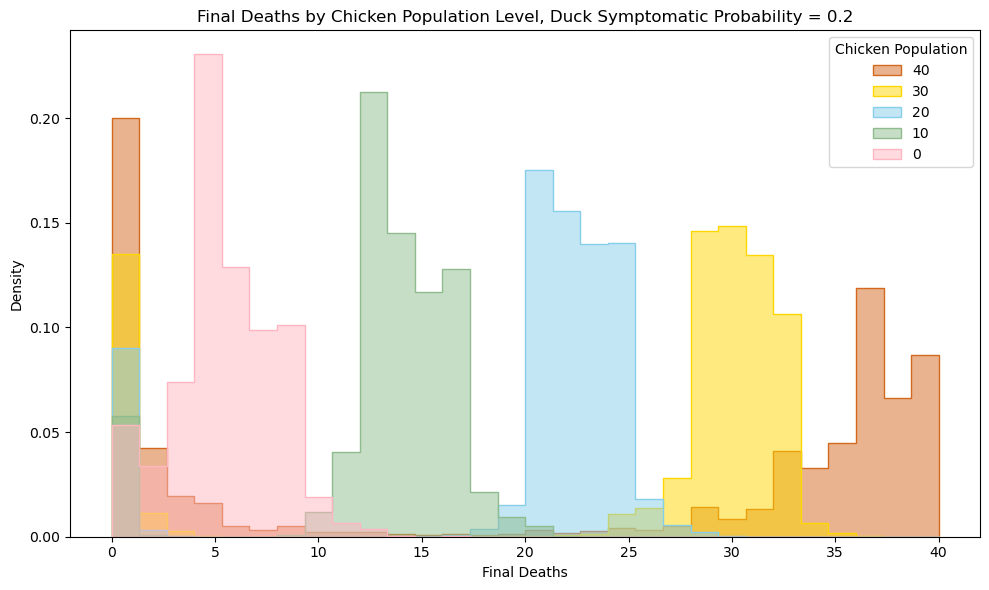

In [99]:
custom_palette = ["#FFB6C1", "#8FBC8F", "#87CEEB", "#FFD700", "#D2691E"]  # Softer, but more intense pastel tones


plt.figure(figsize=(10, 6))
sns.histplot(data=df_all, x="final_deaths", hue="chicken_population", bins=30, element="step", stat="density", common_norm=False, palette=custom_palette, alpha=0.5)
plt.xlabel("Final Deaths")
plt.ylabel("Density")
plt.title("Final Deaths by Chicken Population Level, Duck Symptomatic Probability = {}".format(symprob))
plt.tight_layout()
plt.legend(title="Chicken Population", labels=[40, 30, 20, 10, 0], loc="upper right")
plt.show()

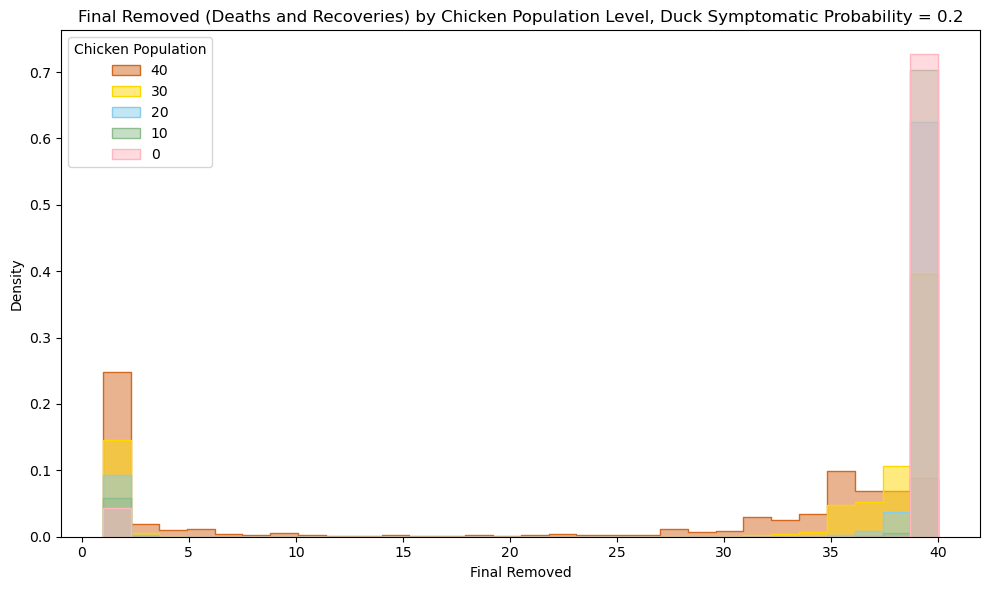

In [100]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_all, x="final_removed", hue="chicken_population", bins=30, element="step", stat="density", common_norm=False, palette=custom_palette, alpha=0.5)
plt.xlabel("Final Removed")
plt.ylabel("Density")
plt.title("Final Removed (Deaths and Recoveries) by Chicken Population Level, Duck Symptomatic Probability = {}".format(symprob))
plt.tight_layout()
plt.legend(title="Chicken Population", labels=[40, 30, 20, 10, 0], loc="upper left")
plt.show()

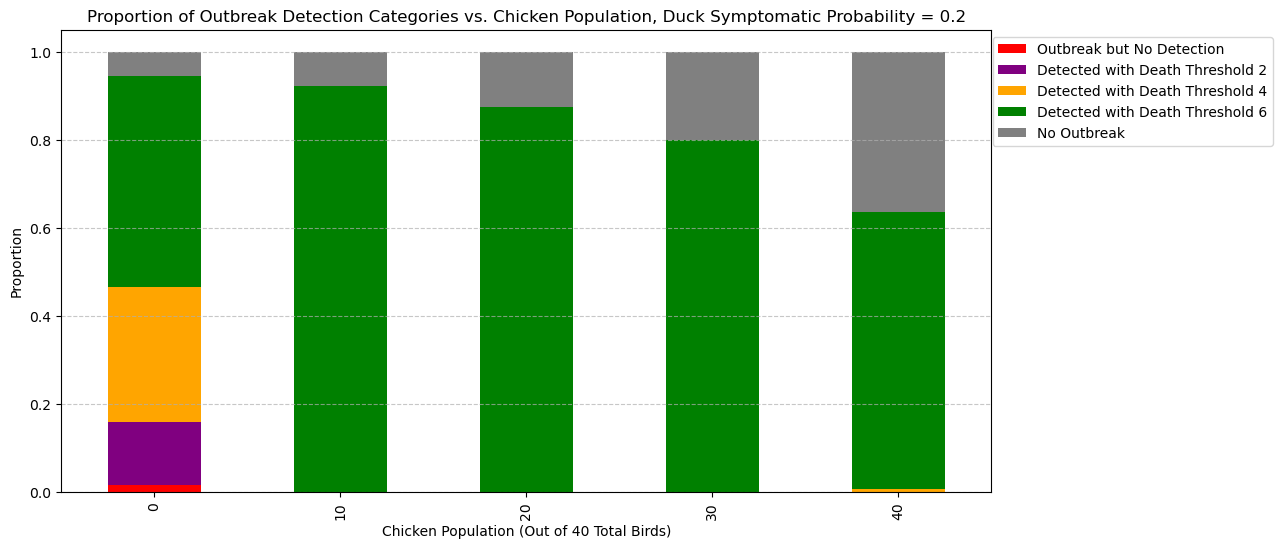

In [101]:
# Classify each simulation into five categories
df_all["outbreak_no_detection"] = (df_all["outbreak"] == True) & df_all[[
    "passive_surveillance_threshold_2", 
    "passive_surveillance_threshold_4", 
    "passive_surveillance_threshold_6"
]].isna().all(axis=1)

df_all["outbreak_and_detected_6"] = (df_all["outbreak"] == True) & df_all["passive_surveillance_threshold_6"].notna()
df_all["outbreak_and_detected_4"] = (df_all["outbreak"] == True) & df_all["passive_surveillance_threshold_4"].notna() & df_all["passive_surveillance_threshold_6"].isna()
df_all["outbreak_and_detected_2"] = (df_all["outbreak"] == True) & df_all["passive_surveillance_threshold_2"].notna() & df_all[[
    "passive_surveillance_threshold_4", 
    "passive_surveillance_threshold_6"
]].isna().all(axis=1)

df_all["no_outbreak"] = df_all["outbreak"] == False

# Group by chicken population and count occurrences of each category
category_counts = df_all.groupby("chicken_population")[[
    "outbreak_no_detection", 
    "outbreak_and_detected_2", 
    "outbreak_and_detected_4", 
    "outbreak_and_detected_6", 
    "no_outbreak"
]].sum()

# Normalize to get proportions
category_proportions = category_counts.div(category_counts.sum(axis=1), axis=0)

# Define colors for each category
colors = ["red", "purple", "orange", "green", "gray"]

# Create a segmented bar plot
category_proportions.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)

# Labels and title
plt.xlabel("Chicken Population (Out of 40 Total Birds)")
plt.ylabel("Proportion")
plt.title(f"Proportion of Outbreak Detection Categories vs. Chicken Population, Duck Symptomatic Probability = {symprob}")
plt.legend([
    "Outbreak but No Detection", 
    "Detected with Death Threshold 2", 
    "Detected with Death Threshold 4", 
    "Detected with Death Threshold 6", 
    "No Outbreak"
], bbox_to_anchor=(1.31, 1), loc="upper right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()



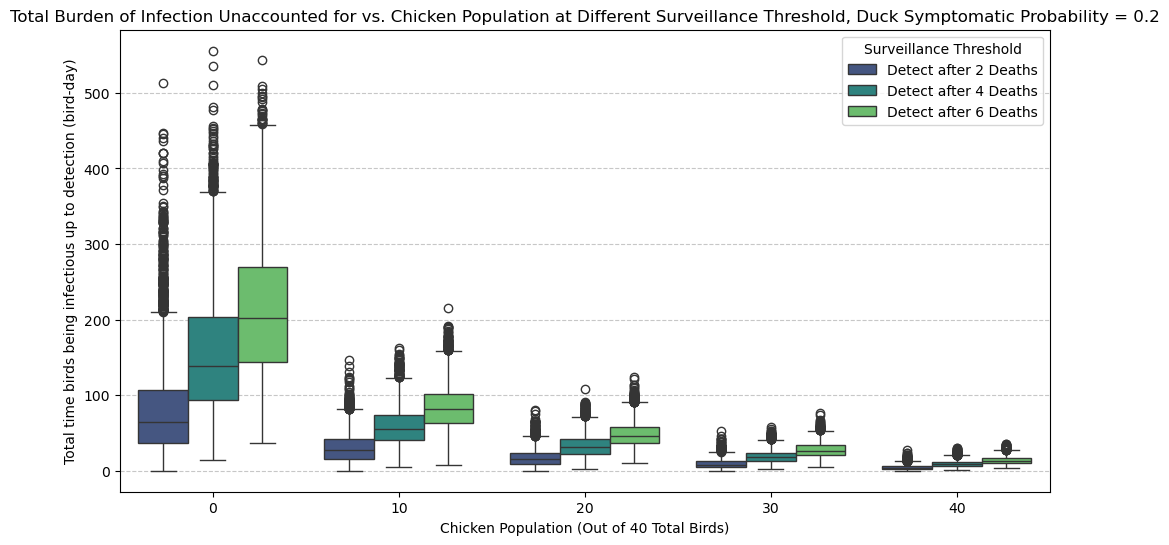

In [102]:
# Reshape the dataframe to long format for multiple thresholds
df_melted = df_all.melt(
    id_vars=["chicken_population"], 
    value_vars=["y2_state", "y4_state", "y6_state"],
    var_name="Surveillance Threshold",
    value_name="Detection Time"
)

# Drop NaN values for visualization
df_melted = df_melted.dropna(subset=["Detection Time"])

# Map threshold names to more readable labels
threshold_labels = {
    "y2_state": "Detect after 2 Deaths",
    "y4_state": "Detect after 4 Deaths",
    "y6_state": "Detect after 6 Deaths"
}
df_melted["Surveillance Threshold"] = df_melted["Surveillance Threshold"].map(threshold_labels)

# Plot the boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x="chicken_population", 
    y="Detection Time", 
    hue="Surveillance Threshold",
    data=df_melted, 
    palette="viridis"
)

# Labels and title
plt.xlabel("Chicken Population (Out of 40 Total Birds)")
plt.ylabel("Total time birds being infectious up to detection (bird-day)")
plt.title(f"Total Burden of Infection Unaccounted for vs. Chicken Population at Different Surveillance Threshold, Duck Symptomatic Probability = {symprob}")
plt.legend(title="Surveillance Threshold")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()